# Projekt 3 - Deep Learning 2



Anna Gnoińska, Julia Ignacyk 

In [1]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow import keras
from sklearn import svm
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings("ignore")

In [2]:
os.listdir('tensorflow-speech-recognition-challenge')

['link_to_gcp_credits_form.txt', 'sample_submission', 'test', 'train']

**Funkcje pomocniczne**


In [3]:
train_audio_path = 'tensorflow-speech-recognition-challenge/train/train/audio/'

def preprocessing(train_audio_path, input_lables):
    labels=os.listdir(train_audio_path)
    all_wave = []
    all_label = []
    for label in labels:
        if label in input_lables:
            print(label)
            waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
            for wav in waves:
                samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
                samples = librosa.resample(samples, sample_rate, 8000)
                if(len(samples)== 8000) : 
                    all_wave.append(samples)
                    all_label.append(label)
                
    
    le = LabelEncoder()    
    transformer = le.fit_transform(all_label)
    unique_labels = list(le.classes_)
    encoded_labels = np_utils.to_categorical(transformer, num_classes=len(unique_labels))
    all_wave = np.array(all_wave).reshape(-1,8000,1)
    
    return (all_wave, encoded_labels, unique_labels)

In [4]:
def select_train_set(size, X, Y):
    print(X.shape, Y.shape)
    X, Y = X[:size], Y[:size]
    x_tr, x_val, y_tr, y_val = train_test_split(X,
                                                Y,
                                                test_size = 0.2,
                                                random_state=666,
                                                shuffle=True)
    return x_tr, x_val, y_tr, y_val

In [5]:
def show_summary(history, X, Y, classnames,file_name):
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()
    
    model=load_model(file_name)
    print("Loaded")
    pred = model.predict(X)
    pred_labels=np.argmax(pred,axis=1)
    print("predicted")

    original_labels=np.argmax(Y,axis=1)
    
    cm = confusion_matrix(original_labels, pred_labels)
    print("\nConfusion matrix:")
    fig = plt.figure(figsize = (10,10))
    sns.heatmap(cm, annot = True, square = True, fmt = 'd', cbar = False)
    plt.show()
    

    print(classification_report(original_labels, pred_labels))


In [24]:
def change_conv_status(model, value):
    for layer in model.layers:
        if(layer.__class__.__name__=='Conv1D'):
            layer.trainable = value
    return model

 **Preprocessing sygnałów audio**

W efekcie przeprowadzonej eksploracji danych ustaliliśmy, że w przypadku niektórych nagrań ich długość jest mniejsza, niż jedna sekunda oraz, że częstotliwość próbkowania wynosi 16 tys Hz. Spośród wszystkich nagrań do dalszej pracy wybieramy tylko te z komendami zapisanymi w tablicy labels. Wykonujemy resampling nagrań do częstotliwości 8 tys HZ i pozostawiamy tylko nagrania jednosekundowe (złożone z 8000 próbek).


In [7]:
all_wave, encoded_labels, unique_labels = preprocessing(train_audio_path,['dog', 'happy', 'nine', 'tree', 'up'])


dog
happy
nine
tree
up


**Wybór zbioru treningowego i walidacyjnego**

Użyjemy 80% danych do treningu, a pozostałe 20% do walidacji wytrenowanego modelu:


In [8]:
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(encoded_labels),stratify=encoded_labels,test_size = 0.2,random_state=777,shuffle=True)

**Budowa modelu**

Budujemy model korzystając z API frameworku Keras. Następnie badamy "skuteczność" klasyfikacji wybranych pięciu słów z bazy nagrań w języku angielskim w zależności od liczebności zbioru treningowego (600, 1200, 2400, 3500, 7000 elementów).

(7082, 8000, 1) (7082, 5)
Epoch 1/100
3/3 [==============================] - 1s 194ms/step - loss: 1.6147 - accuracy: 0.1734 - val_loss: 1.5971 - val_accuracy: 0.1500

Epoch 00001: val_accuracy improved from -inf to 0.15000, saving model to best_model_100.hdf5
Epoch 2/100
3/3 [==============================] - 0s 113ms/step - loss: 1.5736 - accuracy: 0.1961 - val_loss: 1.5817 - val_accuracy: 0.2500

Epoch 00002: val_accuracy improved from 0.15000 to 0.25000, saving model to best_model_100.hdf5
Epoch 3/100
3/3 [==============================] - 0s 113ms/step - loss: 1.5624 - accuracy: 0.2797 - val_loss: 1.5698 - val_accuracy: 0.3000

Epoch 00003: val_accuracy improved from 0.25000 to 0.30000, saving model to best_model_100.hdf5
Epoch 4/100
3/3 [==============================] - 0s 124ms/step - loss: 1.5237 - accuracy: 0.2477 - val_loss: 1.5736 - val_accuracy: 0.3000

Epoch 00004: val_accuracy did not improve from 0.30000
Epoch 5/100
3/3 [==============================] - 0s 123ms/step -

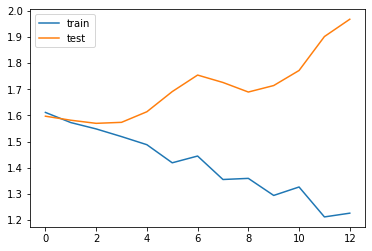

Loaded
predicted

Confusion matrix:


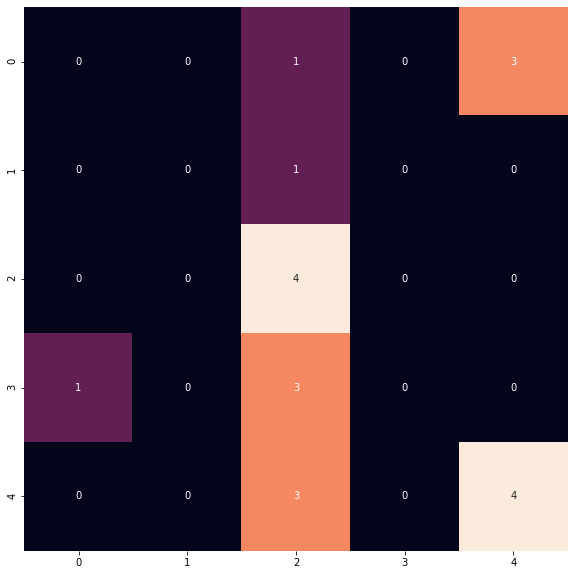

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         1
           2       0.33      1.00      0.50         4
           3       0.00      0.00      0.00         4
           4       0.57      0.57      0.57         7

    accuracy                           0.40        20
   macro avg       0.18      0.31      0.21        20
weighted avg       0.27      0.40      0.30        20



In [64]:
size = 100

K.clear_session()
inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(unique_labels), activation='softmax')(conv)

model = Model(inputs, outputs)

#  wybieramy liczebności zbioru treningowego
X_tr, X_val, Y_tr, Y_val = select_train_set(size, x_tr, y_tr)
    
file_name = 'best_model_' + str(size) +'.hdf5'
    
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint(file_name, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit(X_tr, Y_tr ,epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(X_val,Y_val))
show_summary(history, X_val, Y_val, unique_labels, file_name)

(7082, 8000, 1) (7082, 5)
Epoch 1/100
8/8 [==============================] - 3s 230ms/step - loss: 1.6000 - accuracy: 0.2331 - val_loss: 1.5958 - val_accuracy: 0.2333

Epoch 00001: val_accuracy improved from -inf to 0.23333, saving model to best_model_300.hdf5
Epoch 2/100
8/8 [==============================] - 1s 164ms/step - loss: 1.5681 - accuracy: 0.2911 - val_loss: 1.6021 - val_accuracy: 0.2667

Epoch 00002: val_accuracy improved from 0.23333 to 0.26667, saving model to best_model_300.hdf5
Epoch 3/100
8/8 [==============================] - 1s 169ms/step - loss: 1.5357 - accuracy: 0.3534 - val_loss: 1.5908 - val_accuracy: 0.3000

Epoch 00003: val_accuracy improved from 0.26667 to 0.30000, saving model to best_model_300.hdf5
Epoch 4/100
8/8 [==============================] - 1s 190ms/step - loss: 1.4979 - accuracy: 0.3382 - val_loss: 1.5843 - val_accuracy: 0.3500

Epoch 00004: val_accuracy improved from 0.30000 to 0.35000, saving model to best_model_300.hdf5
Epoch 5/100
8/8 [========

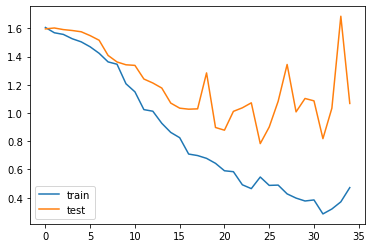

Loaded
predicted

Confusion matrix:


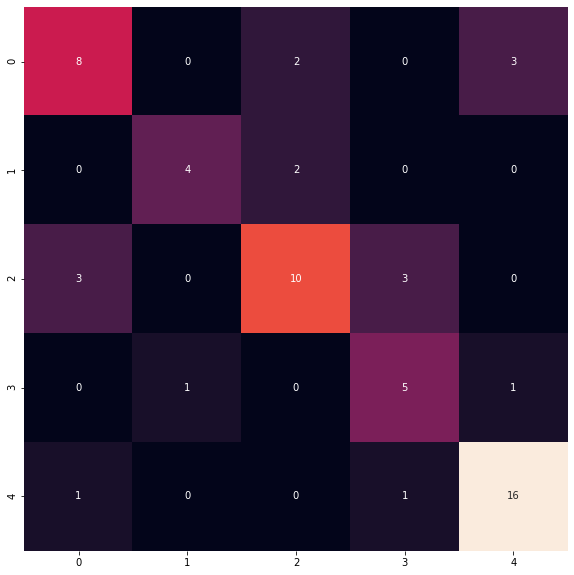

              precision    recall  f1-score   support

           0       0.67      0.62      0.64        13
           1       0.80      0.67      0.73         6
           2       0.71      0.62      0.67        16
           3       0.56      0.71      0.63         7
           4       0.80      0.89      0.84        18

    accuracy                           0.72        60
   macro avg       0.71      0.70      0.70        60
weighted avg       0.72      0.72      0.71        60

(7082, 8000, 1) (7082, 5)
Epoch 1/100
15/15 [==============================] - 4s 183ms/step - loss: 1.5924 - accuracy: 0.2598 - val_loss: 1.5731 - val_accuracy: 0.2667

Epoch 00001: val_accuracy improved from -inf to 0.26667, saving model to best_model_600.hdf5
Epoch 2/100
15/15 [==============================] - 2s 162ms/step - loss: 1.5464 - accuracy: 0.3041 - val_loss: 1.5443 - val_accuracy: 0.3000

Epoch 00002: val_accuracy improved from 0.26667 to 0.30000, saving model to best_model_600.hdf5
Epoch 3/

15/15 [==============================] - 3s 186ms/step - loss: 0.2681 - accuracy: 0.8862 - val_loss: 0.8914 - val_accuracy: 0.6583

Epoch 00036: val_accuracy did not improve from 0.77500
Epoch 00036: early stopping


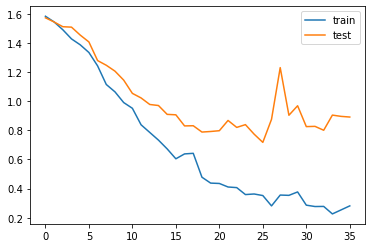

Loaded
predicted

Confusion matrix:


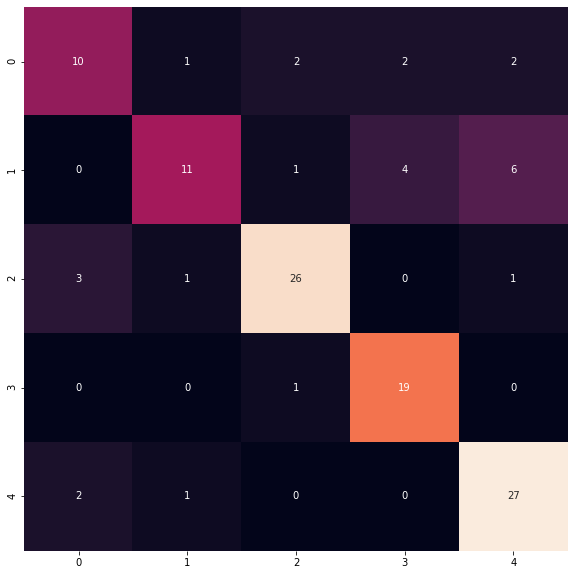

              precision    recall  f1-score   support

           0       0.67      0.59      0.62        17
           1       0.79      0.50      0.61        22
           2       0.87      0.84      0.85        31
           3       0.76      0.95      0.84        20
           4       0.75      0.90      0.82        30

    accuracy                           0.78       120
   macro avg       0.77      0.76      0.75       120
weighted avg       0.78      0.78      0.77       120

(7082, 8000, 1) (7082, 5)
Epoch 1/100
30/30 [==============================] - 6s 164ms/step - loss: 1.6015 - accuracy: 0.2192 - val_loss: 1.5750 - val_accuracy: 0.3083

Epoch 00001: val_accuracy improved from -inf to 0.30833, saving model to best_model_1200.hdf5
Epoch 2/100
30/30 [==============================] - 5s 157ms/step - loss: 1.5280 - accuracy: 0.3209 - val_loss: 1.5465 - val_accuracy: 0.3417

Epoch 00002: val_accuracy improved from 0.30833 to 0.34167, saving model to best_model_1200.hdf5
Epoch 

30/30 [==============================] - 7s 224ms/step - loss: 0.1819 - accuracy: 0.9331 - val_loss: 0.5915 - val_accuracy: 0.8542

Epoch 00036: val_accuracy did not improve from 0.87917
Epoch 37/100
30/30 [==============================] - 5s 162ms/step - loss: 0.1809 - accuracy: 0.9439 - val_loss: 0.6391 - val_accuracy: 0.8417

Epoch 00037: val_accuracy did not improve from 0.87917
Epoch 00037: early stopping


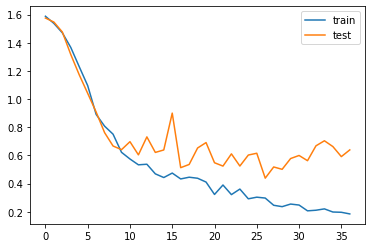

Loaded
predicted

Confusion matrix:


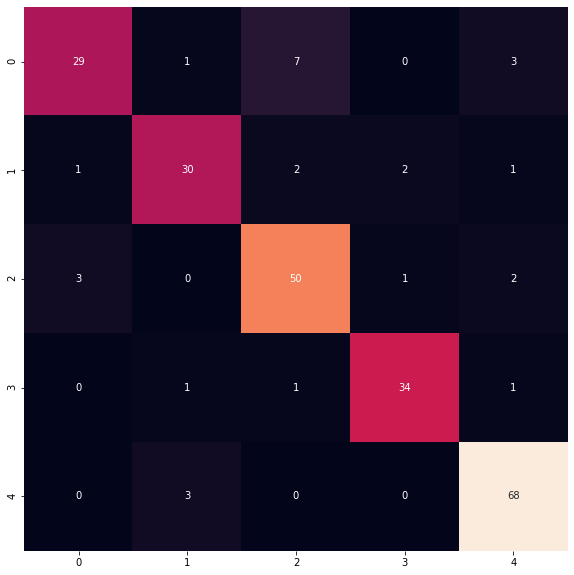

              precision    recall  f1-score   support

           0       0.88      0.72      0.79        40
           1       0.86      0.83      0.85        36
           2       0.83      0.89      0.86        56
           3       0.92      0.92      0.92        37
           4       0.91      0.96      0.93        71

    accuracy                           0.88       240
   macro avg       0.88      0.87      0.87       240
weighted avg       0.88      0.88      0.88       240

(7082, 8000, 1) (7082, 5)
Epoch 1/100
88/88 [==============================] - 16s 168ms/step - loss: 1.5795 - accuracy: 0.2688 - val_loss: 1.5285 - val_accuracy: 0.3343

Epoch 00001: val_accuracy improved from -inf to 0.33429, saving model to best_model_3500.hdf5
Epoch 2/100
88/88 [==============================] - 14s 163ms/step - loss: 1.4063 - accuracy: 0.4048 - val_loss: 1.1495 - val_accuracy: 0.5829

Epoch 00002: val_accuracy improved from 0.33429 to 0.58286, saving model to best_model_3500.hdf5
Epoc

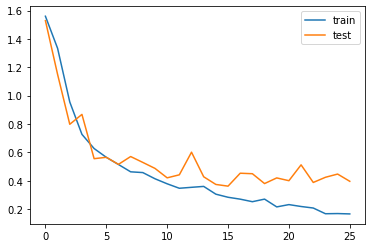

Loaded
predicted

Confusion matrix:


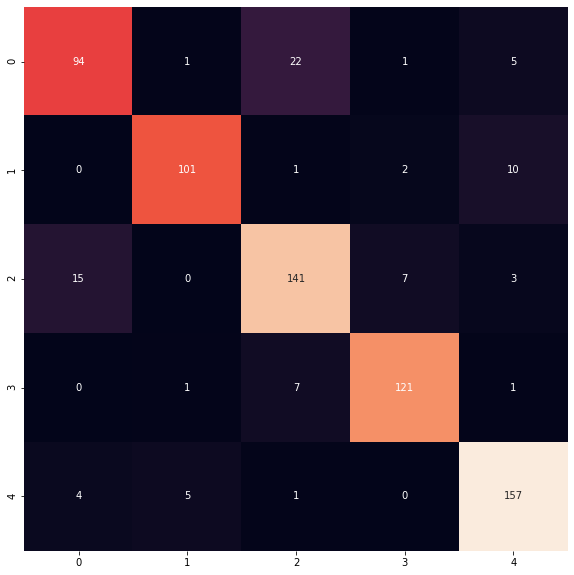

              precision    recall  f1-score   support

           0       0.83      0.76      0.80       123
           1       0.94      0.89      0.91       114
           2       0.82      0.85      0.83       166
           3       0.92      0.93      0.93       130
           4       0.89      0.94      0.92       167

    accuracy                           0.88       700
   macro avg       0.88      0.87      0.88       700
weighted avg       0.88      0.88      0.88       700

(7082, 8000, 1) (7082, 5)
Epoch 1/100
175/175 [==============================] - 24s 131ms/step - loss: 1.5457 - accuracy: 0.3236 - val_loss: 1.1838 - val_accuracy: 0.5786

Epoch 00001: val_accuracy improved from -inf to 0.57857, saving model to best_model_7000.hdf5
Epoch 2/100
175/175 [==============================] - 23s 134ms/step - loss: 0.9954 - accuracy: 0.6455 - val_loss: 0.6646 - val_accuracy: 0.7914

Epoch 00002: val_accuracy improved from 0.57857 to 0.79143, saving model to best_model_7000.hdf5


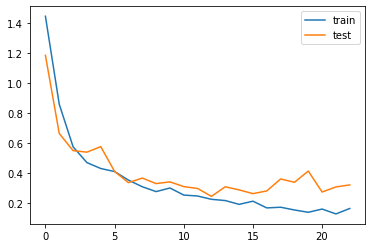

Loaded
predicted

Confusion matrix:


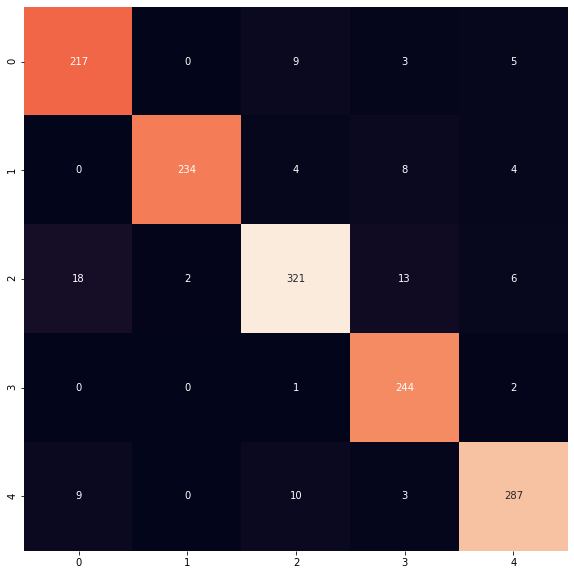

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       234
           1       0.99      0.94      0.96       250
           2       0.93      0.89      0.91       360
           3       0.90      0.99      0.94       247
           4       0.94      0.93      0.94       309

    accuracy                           0.93      1400
   macro avg       0.93      0.93      0.93      1400
weighted avg       0.93      0.93      0.93      1400

(7082, 8000, 1) (7082, 5)
Epoch 1/100
60/60 [==============================] - 11s 167ms/step - loss: 1.5874 - accuracy: 0.2541 - val_loss: 1.5583 - val_accuracy: 0.3000

Epoch 00001: val_accuracy improved from -inf to 0.30000, saving model to best_model_2400.hdf5
Epoch 2/100
60/60 [==============================] - 8s 141ms/step - loss: 1.4583 - accuracy: 0.4025 - val_loss: 1.2396 - val_accuracy: 0.5688

Epoch 00002: val_accuracy improved from 0.30000 to 0.56875, saving model to best_model_2400.hdf5
Epoch

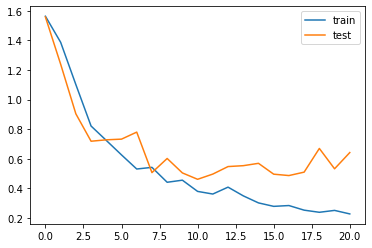

Loaded
predicted

Confusion matrix:


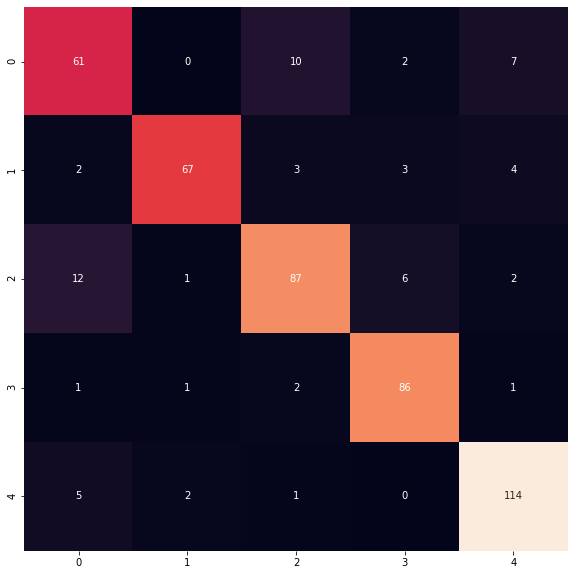

              precision    recall  f1-score   support

           0       0.75      0.76      0.76        80
           1       0.94      0.85      0.89        79
           2       0.84      0.81      0.82       108
           3       0.89      0.95      0.91        91
           4       0.89      0.93      0.91       122

    accuracy                           0.86       480
   macro avg       0.86      0.86      0.86       480
weighted avg       0.87      0.86      0.86       480



In [40]:
for size in [300, 600, 1200, 3500, 7000, 2400]:

    K.clear_session()
    inputs = Input(shape=(8000,1))

    #First Conv1D layer
    conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
    conv = MaxPooling1D(3)(conv)
    conv = Dropout(0.3)(conv)

    #Second Conv1D layer
    conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
    conv = MaxPooling1D(3)(conv)
    conv = Dropout(0.3)(conv)

    #Third Conv1D layer
    conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
    conv = MaxPooling1D(3)(conv)
    conv = Dropout(0.3)(conv)

    #Fourth Conv1D layer
    conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
    conv = MaxPooling1D(3)(conv)
    conv = Dropout(0.3)(conv)

    #Flatten layer
    conv = Flatten()(conv)

    #Dense Layer 1
    conv = Dense(256, activation='relu')(conv)
    conv = Dropout(0.3)(conv)

    #Dense Layer 2
    conv = Dense(128, activation='relu')(conv)
    conv = Dropout(0.3)(conv)

    outputs = Dense(len(unique_labels), activation='softmax')(conv)

    model = Model(inputs, outputs)

    # wybieramy liczebności zbioru treningowego
    X_tr, X_val, Y_tr, Y_val = select_train_set(size, x_tr, y_tr)
    
    file_name = 'best_model_' + str(size) +'.hdf5'
    
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
    mc = ModelCheckpoint(file_name, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    history = model.fit(X_tr, Y_tr ,epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(X_val,Y_val))
    show_summary(history, X_val, Y_val, unique_labels, file_name)

 *WNIOSKI*: Tak jak zakładałyśmy, im większy zbiór treningowy tym dokładność ma większą wartość. 
 
**100** -> 40%

**300**  -> 72%

**600**  -> 78%

**1200** -> 88%

**2400** -> 86%

**3500** -> 87%

**7000** -> 93%



# Pierwsza metoda transfer learning
Zamrażamy wszystkie warstwy konwolucyjne modelu z poprzedniego zadania i trenujemy na nowym zbiorze tylko warstwy gęste.

In [10]:
all_wave2, encoded_labels2, unique_labels2 = preprocessing(train_audio_path,['cat', 'down', 'go', 'wow', 'yes'])


cat
down
go
wow
yes


In [11]:
x_tr2, x_val2, y_tr2, y_val2 = train_test_split(np.array(all_wave2),np.array(encoded_labels2),stratify=encoded_labels2,test_size = 0.2,random_state=777,shuffle=True)

In [69]:
model2 = keras.models.load_model('best_model_7000.hdf5')


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 884, 16)           0     

3/3 [==============================] - 0s 45ms/step - loss: 0.6987 - accuracy: 0.7648 - val_loss: 1.9662 - val_accuracy: 0.3500

Epoch 00026: val_accuracy did not improve from 0.40000
Epoch 27/100
3/3 [==============================] - 0s 49ms/step - loss: 0.6701 - accuracy: 0.7477 - val_loss: 1.9713 - val_accuracy: 0.3500

Epoch 00027: val_accuracy did not improve from 0.40000
Epoch 28/100
3/3 [==============================] - 0s 45ms/step - loss: 0.6425 - accuracy: 0.8508 - val_loss: 1.9836 - val_accuracy: 0.3500

Epoch 00028: val_accuracy did not improve from 0.40000
Epoch 00028: early stopping


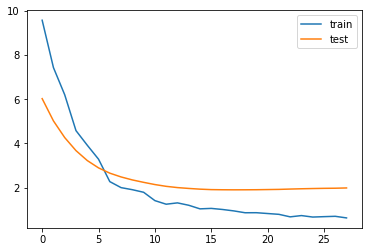

Loaded
predicted

Confusion matrix:


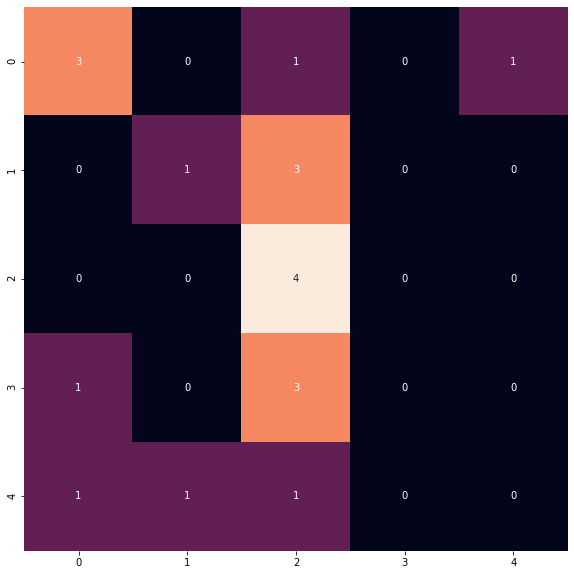

              precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.50      0.25      0.33         4
           2       0.33      1.00      0.50         4
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         3

    accuracy                           0.40        20
   macro avg       0.29      0.37      0.29        20
weighted avg       0.32      0.40      0.32        20

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
__________________________________

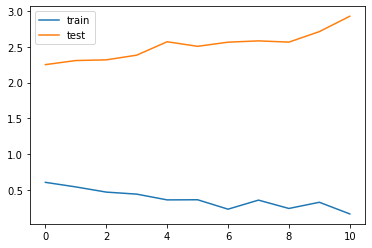

Loaded
predicted

Confusion matrix:


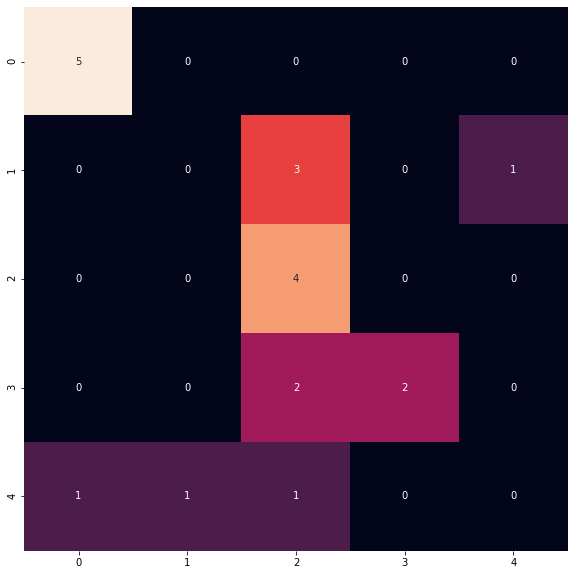

              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       0.00      0.00      0.00         4
           2       0.40      1.00      0.57         4
           3       1.00      0.50      0.67         4
           4       0.00      0.00      0.00         3

    accuracy                           0.55        20
   macro avg       0.45      0.50      0.43        20
weighted avg       0.49      0.55      0.47        20



In [70]:
size = 100

model2 = change_conv_status(model2, False)
model2.summary()
                                           
X_tr2, X_val2, Y_tr2, Y_val2 = select_train_set(size, x_tr2, y_tr2)

file_name = 'best_model_transfer_learing_A.hdf5'
model2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
es2 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc2 = ModelCheckpoint(file_name, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history2 = model2.fit(X_tr2, Y_tr2, epochs=100, callbacks=[es2,mc2], batch_size=32, validation_data=(X_val2,Y_val2))

show_summary(history2, X_val2, Y_val2, unique_labels, file_name)


model2 = change_conv_status(model2, True) 
model2.summary()

model2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
es2 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc2 = ModelCheckpoint(file_name, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history2 = model2.fit(X_tr2, Y_tr2 ,epochs=100, callbacks=[es2,mc2], batch_size=32, validation_data=(X_val2, Y_val2))

show_summary(history2, X_val2, Y_val2, unique_labels, file_name)

*WNIOSKI*: Po zastosowaniu tricku z zamrażaniem wartw i dotrenowaniem sieci dla zbioru o liczebności 300 accuracy wyniosła 40% po zamrożeniu, a po ponownym odmorżeniue wzrosła 55% dla nowych 5 słow. A więc trick z mrożeniem zadziałał lepiej niż w poprzednim zadaniu.

# Druga metoda transfer learning

In [71]:
model = keras.models.load_model('best_model_7000.hdf5')

In [72]:
features = Model(inputs = model.layers[0].input, outputs = model.layers[12].output)

size = 7000
X_tr, X_val, Y_tr, Y_val = select_train_set(size, x_tr2, y_tr2)
    
pred_features = features.predict(X_tr)

labels= np.zeros(7000)
for i,t in enumerate(Y_tr):
    labels[i] = np.where(t==1)[0][0]
    
parameters = {'kernel':('linear','rbf'), 'C':[1,10,100,1000], 'gamma':('scale', 'auto')}

svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=5, verbose=3)

(7560, 8000, 1) (7560, 5)


In [73]:
features.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 884, 16)           0   

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] C=1, gamma=scale, kernel=linear .................................
[CV] ..... C=1, gamma=scale, kernel=linear, score=0.438, total=   0.1s
[CV] C=1, gamma=scale, kernel=linear .................................
[CV] ..... C=1, gamma=scale, kernel=linear, score=0.375, total=   0.0s
[CV] C=1, gamma=scale, kernel=linear .................................
[CV] ..... C=1, gamma=scale, kernel=linear, score=0.625, total=   0.0s
[CV] C=1, gamma=scale, kernel=linear .................................
[CV] ..... C=1, gamma=scale, kernel=linear, score=0.562, total=   0.1s
[CV] C=1, gamma=scale, kernel=linear .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ..... C=1, gamma=scale, kernel=linear, score=0.438, total=   0.1s
[CV] C=1, gamma=scale, kernel=rbf ....................................
[CV] ........ C=1, gamma=scale, kernel=rbf, score=0.250, total=   0.1s
[CV] C=1, gamma=scale, kernel=rbf ....................................
[CV] ........ C=1, gamma=scale, kernel=rbf, score=0.312, total=   0.0s
[CV] C=1, gamma=scale, kernel=rbf ....................................
[CV] ........ C=1, gamma=scale, kernel=rbf, score=0.375, total=   0.1s
[CV] C=1, gamma=scale, kernel=rbf ....................................
[CV] ........ C=1, gamma=scale, kernel=rbf, score=0.438, total=   0.1s
[CV] C=1, gamma=scale, kernel=rbf ....................................
[CV] ........ C=1, gamma=scale, kernel=rbf, score=0.375, total=   0.1s
[CV] C=1, gamma=auto, kernel=linear ..................................
[CV] ...... C=1, gamma=auto, kernel=linear, score=0.438, total=   0.1s
[CV] C=1, gamma=auto, kernel=linear ..................................
[CV] .

[CV] .. C=1000, gamma=scale, kernel=linear, score=0.625, total=   0.1s
[CV] C=1000, gamma=scale, kernel=linear ..............................
[CV] .. C=1000, gamma=scale, kernel=linear, score=0.500, total=   0.0s
[CV] C=1000, gamma=scale, kernel=linear ..............................
[CV] .. C=1000, gamma=scale, kernel=linear, score=0.438, total=   0.1s
[CV] C=1000, gamma=scale, kernel=rbf .................................
[CV] ..... C=1000, gamma=scale, kernel=rbf, score=0.250, total=   0.0s
[CV] C=1000, gamma=scale, kernel=rbf .................................
[CV] ..... C=1000, gamma=scale, kernel=rbf, score=0.375, total=   0.1s
[CV] C=1000, gamma=scale, kernel=rbf .................................
[CV] ..... C=1000, gamma=scale, kernel=rbf, score=0.500, total=   0.1s
[CV] C=1000, gamma=scale, kernel=rbf .................................
[CV] ..... C=1000, gamma=scale, kernel=rbf, score=0.500, total=   0.1s
[CV] C=1000, gamma=scale, kernel=rbf .................................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    4.0s finished


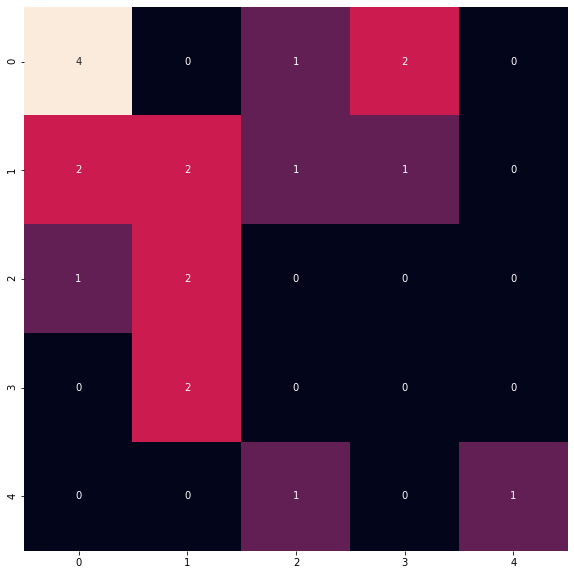

              precision    recall  f1-score   support

         0.0       0.57      0.57      0.57         7
         1.0       0.33      0.33      0.33         6
         2.0       0.00      0.00      0.00         3
         3.0       0.00      0.00      0.00         2
         4.0       1.00      0.50      0.67         2

    accuracy                           0.35        20
   macro avg       0.38      0.28      0.31        20
weighted avg       0.40      0.35      0.37        20



In [74]:
nsamples, nx, ny = pred_features.shape
pred_features = pred_features.reshape((nsamples,nx*ny))

model3=clf.fit(pred_features[:80],labels[:80])
pred = model3.predict(pred_features[80:100])

cm = confusion_matrix(labels[80:100], pred)
print("\nConfusion matrix:")
fig = plt.figure(figsize = (10,10))
sns.heatmap(cm, annot = True, square = True, fmt = 'd', cbar = False)
plt.show()


print(classification_report(labels[80:100], pred))

**WNIOSKI**: Druga metoda dała gorsze rezulaty niż pierwsza dla zbioru o liczebności 100.

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] C=1, gamma=scale, kernel=linear .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... C=1, gamma=scale, kernel=linear, score=0.521, total=   0.4s
[CV] C=1, gamma=scale, kernel=linear .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ..... C=1, gamma=scale, kernel=linear, score=0.521, total=   0.3s
[CV] C=1, gamma=scale, kernel=linear .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV] ..... C=1, gamma=scale, kernel=linear, score=0.354, total=   0.3s
[CV] C=1, gamma=scale, kernel=linear .................................
[CV] ..... C=1, gamma=scale, kernel=linear, score=0.521, total=   0.3s
[CV] C=1, gamma=scale, kernel=linear .................................
[CV] ..... C=1, gamma=scale, kernel=linear, score=0.458, total=   0.3s
[CV] C=1, gamma=scale, kernel=rbf ....................................
[CV] ........ C=1, gamma=scale, kernel=rbf, score=0.438, total=   0.4s
[CV] C=1, gamma=scale, kernel=rbf ....................................
[CV] ........ C=1, gamma=scale, kernel=rbf, score=0.500, total=   0.4s
[CV] C=1, gamma=scale, kernel=rbf ....................................
[CV] ........ C=1, gamma=scale, kernel=rbf, score=0.417, total=   0.4s
[CV] C=1, gamma=scale, kernel=rbf ....................................
[CV] ........ C=1, gamma=scale, kernel=rbf, score=0.521, total=   0.4s
[CV] C=1, gamma=scale, kernel=rbf ....................................
[CV] .

[CV] .. C=1000, gamma=scale, kernel=linear, score=0.562, total=   0.3s
[CV] C=1000, gamma=scale, kernel=linear ..............................
[CV] .. C=1000, gamma=scale, kernel=linear, score=0.479, total=   0.4s
[CV] C=1000, gamma=scale, kernel=linear ..............................
[CV] .. C=1000, gamma=scale, kernel=linear, score=0.396, total=   0.3s
[CV] C=1000, gamma=scale, kernel=linear ..............................
[CV] .. C=1000, gamma=scale, kernel=linear, score=0.458, total=   0.4s
[CV] C=1000, gamma=scale, kernel=linear ..............................
[CV] .. C=1000, gamma=scale, kernel=linear, score=0.500, total=   0.4s
[CV] C=1000, gamma=scale, kernel=rbf .................................
[CV] ..... C=1000, gamma=scale, kernel=rbf, score=0.479, total=   0.5s
[CV] C=1000, gamma=scale, kernel=rbf .................................
[CV] ..... C=1000, gamma=scale, kernel=rbf, score=0.458, total=   0.4s
[CV] C=1000, gamma=scale, kernel=rbf .................................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   29.5s finished



Confusion matrix:


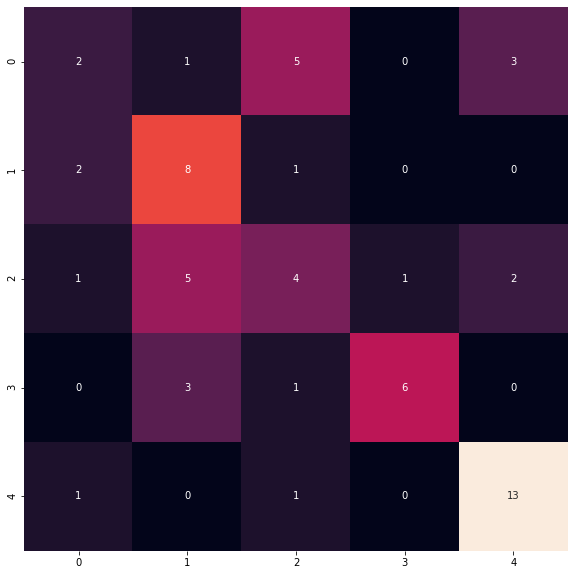

              precision    recall  f1-score   support

         0.0       0.33      0.18      0.24        11
         1.0       0.47      0.73      0.57        11
         2.0       0.33      0.31      0.32        13
         3.0       0.86      0.60      0.71        10
         4.0       0.72      0.87      0.79        15

    accuracy                           0.55        60
   macro avg       0.54      0.54      0.52        60
weighted avg       0.54      0.55      0.53        60



In [76]:

model3=clf.fit(pred_features[:240],labels[:240])
pred = model3.predict(pred_features[240:300])

cm = confusion_matrix(labels[240:300], pred)
print("\nConfusion matrix:")
fig = plt.figure(figsize = (10,10))
sns.heatmap(cm, annot = True, square = True, fmt = 'd', cbar = False)
plt.show()


print(classification_report(labels[240:300], pred))